In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
import numpy as np
import torch
import torch.optim as optim
import pandas as pd
from abn.models.spherical_vae import SphericalVAE
from abn.trainer.svae_trainer import SphericalVAETrainer
from abn.datasets.wiggles import Wiggles
from abn.datasets.data_loader import TrainValLoader

# Hyperspherical VAE

wiggles_dataset = Wiggles()## Load Dataset

In [65]:
dataset = Wiggles(amp_wiggles=0)

/Users/sophia/projects/abn/abn/notebooks/../../abn/datasets/wiggles.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.stack([torch.cos(angle), torch.sin(angle)], axis=0))
/Users/sophia/projects/abn/abn/notebooks/../../abn/datasets/wiggles.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "ik,jk->ij", polar(angles), torch.diag(torch.tensor(amplitudes))
/Users/sophia/projects/abn/abn/notebooks/../../abn/datasets/wiggles.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wiggly_circle = torch.tensor(wiggly_c

## Normalize the Data

Note: Different normalization schemes have a *HUGE* impact on the training procedure.
Options that should be explored include:
- Z-scoring each neuron's response across the entire dataset
- Setting min of the entire dataset to 0 and max to 1
- Setting the norm of each neural state vector to 1

They are each implemented below. Uncomment options to try them out

In [66]:
"""
Z-Scoring
"""
# dataset.data = dataset.data - dataset.data.mean(axis=-1, keepdim=True)
# dataset.data = dataset.data / dataset.data.std(axis=-1, keepdim=True)
# print(dataset.data.std(axis=-1))

'\nZ-Scoring\n'

In [67]:
"""
Min 0 Max 1
"""
# dataset.data = dataset.data - dataset.data.min()
# dataset.data = dataset.data / dataset.data.max()

'\nMin 0 Max 1\n'

In [68]:
"""
Sum to 1
"""
dataset.data = dataset.data - dataset.data.min(axis=-1, keepdim=True)[0]
dataset.data = dataset.data / dataset.data.sum(axis=-1, keepdim=True)

In [69]:
"""
Unit Norm
"""
# dataset.data = dataset.data / torch.linalg.norm(dataset.data, dim=-1, keepdim=True)
# print(torch.linalg.norm(dataset.data, dim=-1))

'\nUnit Norm\n'

## Train Val Split and Generate Batches

In [70]:
data_loader = TrainValLoader(batch_size=20, fraction_val=0.2)
data_loader.load(dataset)

## Construct Model

In [71]:
model = SphericalVAE(input_dim=10,
                     encoder_dims=[10, 10, 5, 5],
                     latent_dim=2,
                     distribution="vmf")

optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = SphericalVAETrainer(model=model, optimizer=optimizer)

In [72]:
model

SphericalVAE(
  (encoder): Sequential(
    (fullyconnected_0): Linear(in_features=10, out_features=10, bias=True)
    (activation_0): ReLU()
    (fullyconnected_1): Linear(in_features=10, out_features=10, bias=True)
    (activation_1): ReLU()
    (fullyconnected_2): Linear(in_features=10, out_features=5, bias=True)
    (activation_2): ReLU()
    (fullyconnected_3): Linear(in_features=5, out_features=5, bias=True)
    (out_3): ReLU()
  )
  (mu): Linear(in_features=5, out_features=2, bias=True)
  (var): Linear(in_features=5, out_features=1, bias=True)
  (decoder): Sequential(
    (fullyconnected_0): Linear(in_features=2, out_features=5, bias=True)
    (activation_0): ReLU()
    (fullyconnected_1): Linear(in_features=5, out_features=5, bias=True)
    (activation_1): ReLU()
    (fullyconnected_2): Linear(in_features=5, out_features=10, bias=True)
    (activation_2): ReLU()
    (fullyconnected_3): Linear(in_features=10, out_features=10, bias=True)
    (activation_3): ReLU()
    (fullyconnec

## Train Model

In [73]:
trainer.train(data_loader, 1000)

/Users/sophia/opt/anaconda3/envs/geomstats/lib/python3.8/site-packages/torch/distributions/distribution.py:45: UserWarning: <class 'abn.hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 0 ||  N Examples 0 || Train Total Loss 6.62652 || Validation Total Loss 6.09364
Epoch 1 ||  N Examples 1200 || Train Total Loss 5.21222 || Validation Total Loss 4.27548
Epoch 2 ||  N Examples 2400 || Train Total Loss 3.78163 || Validation Total Loss 3.52565
Epoch 3 ||  N Examples 3600 || Train Total Loss 3.43319 || Validation Total Loss 3.38843
Epoch 4 ||  N Examples 4800 || Train Total Loss 3.35377 || Validation Total Loss 3.34021
Epoch 5 ||  N Examples 6000 || Train Total Loss 3.31741 || Validation Total Loss 3.30862
Epoch 6 ||  N Examples 7200 || Train Total Loss 3.30201 || Validation Total Loss 3.30295
Epoch 7 ||  N Examples 8400 || Train Total Loss 3.29812 || Validation Total Loss 3.29862
Epoch 8 ||  N Examples 9600 || Train Total Loss 3.29471 || Validation Total Loss 3.29643
Epoch 9 ||  N Examples 10800 || Train Total Loss 3.29289 || Validation Total Loss 3.29615
Epoch 10 ||  N Examples 12000 || Train Total Loss 3.29168 || Validation Total Loss 3.29268
Epoch 11 ||  N Exampl

## Visualize Latent Space

In [74]:
with torch.no_grad():
    (z_mean, z_var), (q_z, p_z), z = model.to_latent(dataset.data)

In [75]:
df = pd.DataFrame({"z0": z[:, 0], 
                    "z1": z[:, 1], 
                    "pos": dataset.labels})
#                     "pos": (dataset.pos + dataset.angle) % (2 * np.pi)})

<AxesSubplot:xlabel='z0', ylabel='z1'>

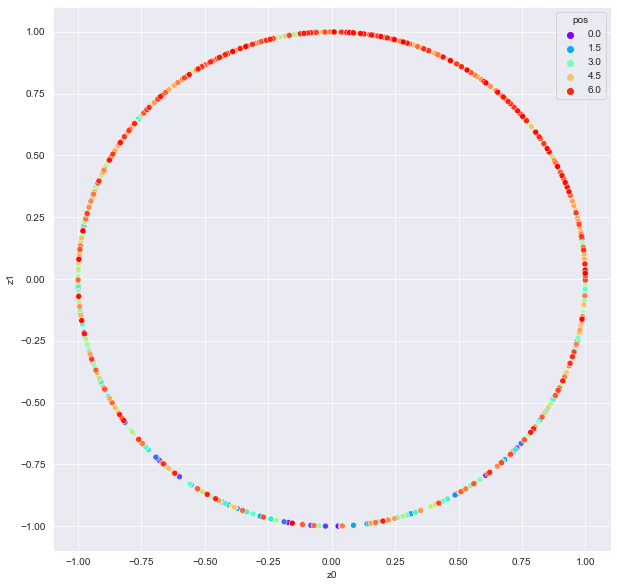

In [76]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="z0", y="z1", hue="pos", data=df, palette="rainbow")